In [1]:
from utils_filter import *
from utils_datetime import *
from utils_geography import *
from utils_plotting import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import metpy
import numbers
from matplotlib.patches import FancyArrowPatch

In [2]:
data_location = 'data'
pph = xr.load_dataset('data/pph/labelled2023_pph_final.nc')
reports = gp.read_file(data_location + '/storm_reports/labelled2023_reports_final.csv')

In [4]:
displacements = xr.load_dataset('data/displacement/displacements_final2.nc')

In [5]:
grid_outlook_location = 'data/outlooks/grid_outlooks_final.nc'
grid_report_location = 'data/storm_reports/grid_reports2.nc'

grid_outlooks = xr.open_dataset(grid_outlook_location)
grid_reports = xr.open_dataset(grid_report_location)

In [6]:
def performance_diagram(pods, fars, obj_labels, colors, markers, filename = '', save = False, show = True, figsize=(9, 8), points = True, xlabel="Success Ratio (1-FAR)",
                        ylabel="Probability of Detection", ticks=np.arange(0, .6, 0.1), dpi=300, csi_cmap="Blues",
                        csi_label="Critical Success Index", title="Performance Diagram",
                        legend_params=dict(loc=4, fontsize=12, framealpha=1, frameon=True)):
    """
    Draws a performance diagram from a set of POD lists and FAR lists.
    :param pods: list or array of POD arrays.
    :param fars: list or array of FAR arrays.
    :param obj_labels: list or array of labels describing each DistributedROC object.
    :param colors: list of color strings
    :param markers: list of markers.
    :param filename: output filename.
    :param save: whether the figure will be saved
    :param show: whether the figure will be shown in the console
    :param figsize: tuple with size of the figure in inches.
    :param points: True if the plotted points should be separate, otherwise connected
    :param xlabel: Label for the x-axis
    :param ylabel: Label for the y-axis
    :param ticks: Array of ticks used for x and y axes
    :param dpi: DPI of the output image
    :param csi_cmap: Colormap used for the CSI contours
    :param csi_label: Label for the CSI colorbar
    :return:
    """
    plt.style.use('default')
    plt.figure(figsize=figsize)
    grid_ticks = np.arange(0, .51, 0.01)
    sr_g, pod_g = np.meshgrid(grid_ticks, grid_ticks)
    bias = pod_g / sr_g
    csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)
    csi_contour = plt.contourf(sr_g, pod_g, csi, np.arange(.025, .325, 0.025), extend="max", cmap=csi_cmap)
    b_contour = plt.contour(sr_g, pod_g, bias, [.25, 0.5, 1, 2, 4], colors="k", linestyles="dashed")
    plt.clabel(b_contour, fmt="%1.2f", manual=[(0.1, 0.45), (0.2, 0.45), (0.35, 0.35), (.45, .2), (.45, .1)])
    for r, pod, far in zip(range(len(pods)), pods, fars):
        if points:
            plt.scatter(1 - far, pod, marker=markers[r], color=colors[r], label=obj_labels[r], s = 100)
        else:
            plt.plot(1 - far, pod, marker=markers[r], color=colors[r], label=obj_labels[r], markersize = 5, linewidth = 1)
            shift0 = .03
            shift1 = .03
            if r == 3:
                shift1 = 0
            plt.annotate('2002', xy = (1-far[1], pod[1]), xytext=(1-far[1]-shift1, pod[1]+shift0), arrowprops=dict(arrowstyle="->"))
            plt.annotate('2023', xy = (1-far[-1], pod[-1]), xytext=(1-far[-1]+shift0, pod[-1]-shift1), arrowprops=dict(arrowstyle="->"))
    cbar = plt.colorbar(csi_contour)
    cbar.set_label(csi_label, fontsize=14)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.xticks(ticks)
    plt.yticks(ticks)
    plt.title(title, fontsize=14, fontweight="bold")
    plt.text(0.24,0.26,"Frequency Bias",fontdict=dict(fontsize=14, rotation=48))

    if len(obj_labels) > 8:
        legend_params=dict(loc='center left', bbox_to_anchor=(1.3, 0.5), fontsize=12, framealpha=1, frameon=True)
    
    plt.legend(**legend_params)

    if save:
        plt.savefig(filename, dpi=dpi, bbox_inches="tight")
    #if show:
    #    plt.show()


In [7]:
def plot_outlooks_day(outlooks_date, output_location, categories, title_date, show=False, save = True):
    # plots day 1, 2, and 3 outlooks for a day of given categories (hail, wind, tornado, categorical)
    outlooks_date['PRODISS'] = parse_datetime(outlooks_date['PRODISS'])
    for category in categories:
        outlooks_category = outlooks_date[outlooks_date['CATEGORY'] == category]
        for day in [[3, 8], [2, 7], [2, 17], [1, 6]]: 
            outlooks_category_day = outlooks_category[(outlooks_category['DAY'] == day[0]) & (outlooks_category['CYCLE'] == day[1])]
            latest_issue_time = np.max(outlooks_category_day['PRODISS'])
            outlooks_category_day = outlooks_category_day[outlooks_category_day['PRODISS'] == latest_issue_time]
            if outlooks_category_day.empty == False:
                fig=plt.figure(figsize=(9,6))
                plt.style.use('dark_background')
                ax = plt.axes(projection = cp.crs.LambertConformal())
                ax.add_feature(cp.feature.LAND,facecolor='grey')
                ax.add_feature(cp.feature.OCEAN, alpha = 0.5)
                ax.add_feature(cp.feature.COASTLINE,linewidth=0.5)
                ax.add_feature(cp.feature.LAKES, alpha = 0.5)
                ax.add_feature(cp.feature.STATES,linewidth=0.5)
                outlooks_category_day.plot('THRESHOLD', legend = True)
                plt.title(title_date + ' Day ' + str(day) + ' ' + category + ' outlook for ' + str(outlooks_category_day['DATE'].iloc[0]))
                cx.add_basemap(ax, crs=outlooks_category_day.crs)
                if save:
                    plt.savefig(output_location + '/day' + str(day) + '_' + category + '_' + str(outlooks_category_day['DATE'].iloc[0]) + '.png')
                if not show:
                    plt.close()

def plot_grid_outlooks_day(grid_outlooks_date, output_location, title_date, show=False, save = True):
    # plots day 3, day 2, and day 2 outlooks for a day. Assume that grid_outlooks_date only contains one day
    for day in ['Day 3', 'Day 2 7', 'Day 2 17', 'Day 1']: 
        grid_outlooks_date_outlook = grid_outlooks_date.sel(outlook = day)
        fig=plt.figure(figsize=(9,6))
        plt.style.use('dark_background')
        ax = plt.axes(projection = cp.crs.LambertConformal())
        ax.add_feature(cp.feature.LAND,facecolor='grey')
        ax.add_feature(cp.feature.OCEAN, alpha = 0.5)
        ax.add_feature(cp.feature.COASTLINE,linewidth=0.5)
        ax.add_feature(cp.feature.LAKES, alpha = 0.5)
        ax.add_feature(cp.feature.STATES,linewidth=0.5)

        plt.contourf(grid_outlooks_date_outlook.lon.values, grid_outlooks_date_outlook.lat.values, grid_outlooks_date_outlook['prob'].values[:,:],
                    levels=[0,.02], colors=['#FFFFFF'],
                    transform=cp.crs.PlateCarree(), alpha=0.)
        try:
            c = plt.contourf(grid_outlooks_date_outlook.lon.values, grid_outlooks_date_outlook.lat.values, grid_outlooks_date_outlook['prob'].values[:,:]+.01,
                    levels=[.02,.05,.10,.15,.30,.45,.60,1.00], colors=['#008b00','#8b4726','#ffc800', '#ff0000', '#ff00ff', '#912cee', '#104e8b'],
                    transform=cp.crs.PlateCarree())
            
        except:
            plt.annotate("No Severe Thunderstorms Forecast", xy=(0.5, 0.5), xycoords="figure fraction",
                        va="center", ha="center", color='white',
                        bbox=dict(boxstyle="round", fc="k"))
        
        ax.set_extent([-121, -71, 23, 50])
        plt.title(title_date + ' ' + day + ' Any-Hazard Outlook')
        plt.colorbar(c,orientation="horizontal", pad=0.01, aspect=50,fraction=.1)
        if save:
            plt.savefig(output_location + '/outlook_' + str.replace(day, ' ', '_') + '.png')
        if not show:
            plt.close()

def plot_pph_day(pph_date, output_location, categories, title_date, show = False, save = True, sig = True):
    for category in categories:
        pph_date_category = pph_date[['p_perfect_' + category, 'lat', 'lon']]
        if sig:
            pph_date_category_sig = pph_date[['p_perfect_sig_' + category, 'lat', 'lon']]

        
        # credit: https://atlas.niu.edu/pperfect/BAMS/notebook_sample.html
        fig=plt.figure(figsize=(9,6))
        plt.style.use('dark_background')
        ax = plt.axes(projection = cp.crs.LambertConformal())
        ax.add_feature(cp.feature.LAND,facecolor='grey')
        ax.add_feature(cp.feature.OCEAN, alpha = 0.5)
        ax.add_feature(cp.feature.COASTLINE,linewidth=0.5)
        ax.add_feature(cp.feature.LAKES, alpha = 0.5)
        ax.add_feature(cp.feature.STATES,linewidth=0.5)

        plt.contourf(pph_date_category.lon.values, pph_date_category.lat.values, pph_date_category['p_perfect_' + category].values[:,:]/100,
                    levels=[0,2], colors=['#FFFFFF'],
                    transform=cp.crs.PlateCarree(), alpha=0.)
        try:
            c = plt.contourf(pph_date_category.lon.values, pph_date_category.lat.values, pph_date_category['p_perfect_' + category].values[:,:]/100,
                    levels=[.02,.05,.10,.15,.30,.45,.60,1.00], colors=['#008b00','#8b4726','#ffc800', '#ff0000', '#ff00ff', '#912cee', '#104e8b'],
                    transform=cp.crs.PlateCarree())
            plt.annotate('PPH Max\n'+str(pph_date_category['p_perfect_' + category].values[:,:].max().round(1))+'%', xy=(0.88, 0.3), xycoords="figure fraction",
                        va="center", ha="center", color='white',fontsize=12,
                        bbox=dict(boxstyle="round", fc="k"))
        except:
            plt.annotate("No Reports", xy=(0.5, 0.5), xycoords="figure fraction",
                        va="center", ha="center", color='white',
                        bbox=dict(boxstyle="round", fc="k"))
            
        if sig:    
            try:
                plt.contourf(pph_date_category_sig.lon.values, pph_date_category_sig.lat.values, pph_date_category_sig['p_perfect_sig_' + category].values[0,:,:],
                        levels=[10,100], colors='none', hatches=['////'],
                        transform=cp.crs.PlateCarree())
                plt.contour(pph_date_category_sig.lon.values, pph_date_category_sig.lat.values, pph_date_category_sig['p_perfect_sig_' + category].values[0,:,:],
                        levels=[10,100], colors=['k'],
                        transform=cp.crs.PlateCarree())
            except:
                pass

        if category == 'tor':
            cat_title = 'Tornado'
        elif category == 'hail':
            cat_title = 'Hail'
        elif category == 'wind':
            cat_title = 'Wind'
        else:
            cat_title = 'All Hazards'

        ax.set_extent([-121, -71, 23, 50])
        plt.title(title_date + ' 24 Hour Practically Perfect Hindcast for ' + cat_title)
        plt.colorbar(c,orientation="horizontal", pad=0.01, aspect=50,fraction=.1)
        if save:
            plt.savefig(output_location + '/pph_' + category + '.png')
        if not show:
            plt.close()

def plot_reports(reports, output_location, categories, title_date, show = False, save = True):
    # plots all storm reports in reports
    legend = []
    fig=plt.figure(figsize=(9,6))
    plt.style.use('dark_background')
    ax = plt.axes(projection = cp.crs.LambertConformal())
    ax.add_feature(cp.feature.LAND,facecolor='grey')
    ax.add_feature(cp.feature.OCEAN, alpha = 0.5)
    ax.add_feature(cp.feature.COASTLINE,linewidth=0.5)
    ax.add_feature(cp.feature.LAKES, alpha = 0.5)
    ax.add_feature(cp.feature.STATES,linewidth=0.5)

    for category in categories:
        reports_category = reports[reports['EVENT_TYPE'] == category]
        reports_category = reports_category[reports_category['BEGIN_LAT'] != '']
        reports_category = reports_category[reports_category['BEGIN_LON'] != '']

        m1 = '.'
        # remove sub-severe
        if category == 'Hail':
            reports_sig = reports_category[reports_category['MAGNITUDE'].astype(float) >= 2.0]
            reports_category = reports_category[(reports_category['MAGNITUDE'].astype(float) >= 1.0) & (reports_category['MAGNITUDE'].astype(float) < 2.0)]
            if not reports_category.empty:
                c1 = 'LimeGreen'
                legend.append('Hail')
            if not reports_sig.empty:
                c2 = 'DarkGreen'
                m2 = '^'
                legend.append('Sig Hail')

        elif category == 'Thunderstorm Wind':
            reports_sig = reports_category[reports_category['MAGNITUDE'].astype(float) >= 65]
            reports_category = reports_category[(reports_category['MAGNITUDE'].astype(float) >= 50) & (reports_category['MAGNITUDE'].astype(float) <65)]
            
            if not reports_category.empty:
                c1 = 'Blue'
                legend.append('Wind')
            if not reports_sig.empty:
                c2 = 'DarkBlue'
                m2 = ','
                legend.append('Sig Wind')
            
            
        else:
            reports_sig = reports_category[[(cat[-1] != 'U' and cat[-1] != '0' and cat[-1] != '1') for cat in reports_category['TOR_F_SCALE']]]
            reports_category = reports_category[[(cat[-1] == 'U' or cat[-1] == '0' or cat[-1] == '1') for cat in reports_category['TOR_F_SCALE']]]
            
            if not reports_category.empty:
                c1 = 'Red'
                legend.append('Tornado')
            if not reports_sig.empty:  
                c2 = 'DarkRed'
                m2 = 'v'
                legend.append('Sig Tornado')
        

        # plot severe
        if not reports_category.empty:
            ax.scatter(reports_category['BEGIN_LON'].values.astype(float), reports_category['BEGIN_LAT'].values.astype(float), transform=cp.crs.PlateCarree(), marker = m1, color = c1)
        if not reports_sig.empty:
            ax.scatter(reports_sig['BEGIN_LON'].values.astype(float), reports_sig['BEGIN_LAT'].values.astype(float), transform=cp.crs.PlateCarree(), marker = m2, color = c2)


    plt.title(title_date + ' Storm Reports')
    plt.legend(legend)
    if save:
        plt.savefig(output_location + '/reports.png')
    if not show:
        plt.close()


pph_key_dict = {
    'Wind': 'p_perfect_wind',
    'Hail': 'p_perfect_hail',
    'Tornado': 'p_perfect_tor',
    'All Hazard': 'p_perfect_totalsvr'
}

outlook_key_dict = {
    'Wind': 'Day 1 Wind',
    'Hail': 'Day 1 Hail',
    'Tornado': 'Day 1 Tornado',
    'All Hazard': 'Day 1'
}


def plot_displacement_day(displacements_date, hazards, grid_outlooks_date, grid_pph_date, output_location, title_date, show = False, save = True):
    for hazard in hazards:
        pph_array = grid_pph_date[pph_key_dict[hazard]].data
        outlook_array = grid_outlooks_date.sel(outlook = outlook_key_dict[hazard])['prob']
        x_flow = displacements_date.sel(hazard = hazard)['x_flow']
        y_flow = displacements_date.sel(hazard = hazard)['y_flow']
        end_lon = displacements_date.sel(hazard = hazard)['end_lon']
        end_lat = displacements_date.sel(hazard = hazard)['end_lat']
        lons = grid_pph_date.lon.values
        lats = grid_pph_date.lat.values

        fig=plt.figure(figsize=(9,6), dpi = 1000)
        ax = plt.axes(projection = cp.crs.LambertConformal())
        ax.add_feature(cp.feature.LAND,facecolor='grey')
        ax.add_feature(cp.feature.OCEAN, alpha = 0.5)
        ax.add_feature(cp.feature.COASTLINE,linewidth=0.5)
        ax.add_feature(cp.feature.LAKES, alpha = 0.5)
        ax.add_feature(cp.feature.STATES,linewidth=0.5)
        c = ax.contourf(lons, lats, outlook_array + .01,
                            levels=[.02,.05,.10,.15,.30,.45,.60,1.00], colors=['#008b00','#8b4726','#ffc800', '#ff0000', '#ff00ff', '#912cee', '#104e8b'], transform=cp.crs.PlateCarree())
        ax.contour(lons, lats, pph_array / 100, levels=[.02,.05,.10,.15,.30,.45,.60,1.00], colors = 'black', linestyles = 'dashed', linewidths = .5, transform=cp.crs.PlateCarree())

        for i in range(lons.shape[0]):
            for j in range(lats.shape[1]):
                if np.abs(x_flow[i, j]) > .01 and np.abs(y_flow[i, j]) > .01:
                    ax.add_patch(FancyArrowPatch((lons[i, j], lats[i, j]), (end_lon[i, j], end_lat[i, j]), transform=cp.crs.PlateCarree(), color = 'black', mutation_scale=4, linewidth = .01))
        plt.title(title_date + ' ' + hazard + ' Outlook Probabilities (colored), PPH Probabilities (dotted), Displacement Vectors')
        plt.colorbar(c,orientation="horizontal", pad=0.01, aspect=50,fraction=.1)
        if save:
            plt.savefig(output_location + '/' + hazard + '_displacement.png')
        if not show:
            plt.close()


In [11]:
# with utils_plotting functions
def plot_day(datestring, grid_outlooks, pph, displacements, reports, folder = 'plots/daily/', show = True, save = False):
    grid_outlooks_day = grid_outlooks.sel(time=datestring)
    pph_day = pph.sel(time=datestring)
    reports_day = reports[reports['DATE'] == datestring]
    displacements_day = displacements.sel(time = datestring)

    titledate = dt.strptime(datestring, "%Y%m%d%H%M").strftime("%m/%d/%Y")

    path = folder+datestring
    

    if save:
        if not os.path.exists(path):
            os.makedirs(path)
    
    #print('plotting outlooks')
    #plot_grid_outlooks_day(grid_outlooks_day, path, titledate, show = show, save = save)
    
    print('plotting pph')
    plot_pph_day(pph_day, path, ['max'], titledate, show=show, save = save, sig = False)

    #print('plotting reports')
    #plot_reports(reports_day, path, ['Hail', 'Thunderstorm Wind', 'Tornado'], titledate, show=show, save = save)

    print('plotting displacements')
    plot_displacement_day(displacements_day, ['Wind', 'Hail', 'Tornado', 'All Hazard'], grid_outlooks_day, pph_day, path, titledate, show = show, save = save)
    
    print('plotting performance diagram')
    d = performance_diagram([float(pph_day['POD_NUM']), float(pph_day['POD_W_NUM']), float(pph_day['POD_H_NUM']), float(pph_day['POD_T_NUM'])], 
                        [float(pph_day['FAR_NUM']), float(pph_day['FAR_W_NUM']), float(pph_day['FAR_H_NUM']), float(pph_day['FAR_T_NUM'])], 
                        ['All Hazard', 'Wind', 'Hail', 'Tornado', 'All Hazard'], ['black', 'blue', 'green', 'red'], ['o', 'o', 'o', 'o'], 
                        filename = path + '/peformance_diagram.png', save = save, show = show, figsize=(9, 8), points = True, xlabel="Success Ratio (1-FAR)",
                        ylabel="Probability of Detection", ticks=np.arange(0, .6, 0.1), dpi=300, csi_cmap="Blues",
                        csi_label="Critical Success Index", title=titledate + " Performance Diagram",
                        legend_params=dict(loc=4, fontsize=12, framealpha=1, frameon=True))
    
    labelstrs = ''
    labels = ['MAX_CAT', 'RAMP_UP', 'RAMP_DOWN', 'RAMP_CAT', 'SEASON', 'PPH_CAT', 'PPH_NUM', 'REPORT_NUM', 'TOR_NUM', 'WIND_NUM', 'HAIL_NUM', 'TOR_F', 'WINDSP_CAT', 'WINDSP_NUM', 'HAILSZ_CAT', 'HAILSZ_NUM', 'NEIGH_NUM', 'RMSE_NUM', 'BS_NUM', 
              'REGION_M', 'LAT_NUM', 'LON_NUM', 'PPH_D_CAT', 'PPH_D_NUM',
              'POD_NUM', 'FAR_NUM', 'POD_H_NUM', 'FAR_H_NUM', 'POD_W_NUM', 'FAR_W_NUM', 'POD_T_NUM', 'FAR_T_NUM', 
              'E_SH_NUM','N_SH_NUM','DIV_NUM',
              'E_SH_W_NUM', 'N_SH_W_NUM', 'DIV_W_NUM',
              'E_SH_H_NUM', 'N_SH_H_NUM', 'DIV_H_NUM',
              'E_SH_T_NUM', 'N_SH_T_NUM', 'DIV_T_NUM',
              'PC_W_NUM', 'PC_H_NUM', 'PC_T_NUM', 'PC_NUM',
              'POFD_W_NUM', 'POFD_H_NUM', 'POFD_T_NUM', 'POFD_NUM',
              'DFR_W_NUM', 'DFR_H_NUM', 'DFR_T_NUM', 'DFR_NUM', 
              'CSI_W_NUM', 'CSI_H_NUM', 'CSI_T_NUM', 'CSI_NUM', 
              'Bias_W_NUM', 'Bias_H_NUM', 'Bias_T_NUM', 'Bias_NUM',
              'ETS_W_NUM', 'ETS_H_NUM', 'ETS_T_NUM', 'ETS_NUM',
              'TSS_W_NUM', 'TSS_H_NUM', 'TSS_T_NUM', 'TSS_NUM']
    for label in labels:
        labelstr = label + ': ' + str(pph_day[label].data)
        labelstrs += labelstr + '\n'
    if show:
        print(labelstrs)
    if save:
        with open(path + '/labels.txt', "w") as file:
            file.write(labelstrs)
    return


In [ ]:
# to determine dates of interest
mdt_outlooks = outlooks[outlooks['MAX_CAT'].isin(['MDT', 'HIGH'])]
mdt_outlooks = mdt_outlooks[mdt_outlooks['DATE'] >= '200203300000']
mdt_outlooks[mdt_outlooks['FAR_NUM'] == 0]['DATE'].unique()

In [ ]:
dates_of_interest = ['200703280000', '201905200000', '200306220000', '200504220000', '200509140000', '200510240000', '200612010000', '201010100000', '201104040000', '201104270000', '201305310000', '201701220000', '201704020000', '201704050000', '201705180000', '202103170000', '202103250000']
dates_of_interest = ['202303310000']
for date in dates_of_interest:
    print(date)
    plot_day(date, grid_outlooks, pph, displacements, reports, show = False, save = True)

200703280000
plotting pph
plotting displacements
plotting performance diagram


C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: divide by zero encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: invalid value encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:30: RuntimeWarning: divide by zero encountered in divide
  csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)


201905200000
plotting pph
plotting displacements
plotting performance diagram


C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: divide by zero encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: invalid value encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:30: RuntimeWarning: divide by zero encountered in divide
  csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)


200306220000
plotting pph
plotting displacements
plotting performance diagram


C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: divide by zero encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: invalid value encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:30: RuntimeWarning: divide by zero encountered in divide
  csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)


200504220000
plotting pph
plotting displacements


200204190000
plotting performance diagram


C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: divide by zero encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: invalid value encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:30: RuntimeWarning: divide by zero encountered in divide
  csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)


200204200000
plotting performance diagram


C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: divide by zero encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: invalid value encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:30: RuntimeWarning: divide by zero encountered in divide
  csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)


200204210000
plotting performance diagram


C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: divide by zero encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: invalid value encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:30: RuntimeWarning: divide by zero encountered in divide
  csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)


200204250000
plotting performance diagram


C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: divide by zero encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: invalid value encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:30: RuntimeWarning: divide by zero encountered in divide
  csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)


200205060000
plotting performance diagram


C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: divide by zero encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: invalid value encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:30: RuntimeWarning: divide by zero encountered in divide
  csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)


200205250000
plotting performance diagram


C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: divide by zero encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: invalid value encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:30: RuntimeWarning: divide by zero encountered in divide
  csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)


200207310000
plotting performance diagram


C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: divide by zero encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: invalid value encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:30: RuntimeWarning: divide by zero encountered in divide
  csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)


200208130000
plotting performance diagram


C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: divide by zero encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: invalid value encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:30: RuntimeWarning: divide by zero encountered in divide
  csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)


200208300000
plotting performance diagram


C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: divide by zero encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: invalid value encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:30: RuntimeWarning: divide by zero encountered in divide
  csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)


200211090000
plotting performance diagram


C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: divide by zero encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: invalid value encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:30: RuntimeWarning: divide by zero encountered in divide
  csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)


200212230000
plotting performance diagram


C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: divide by zero encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: invalid value encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:30: RuntimeWarning: divide by zero encountered in divide
  csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)


200302030000
plotting performance diagram


C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: divide by zero encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: invalid value encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:30: RuntimeWarning: divide by zero encountered in divide
  csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)


200303250000
plotting performance diagram


C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: divide by zero encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: invalid value encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:30: RuntimeWarning: divide by zero encountered in divide
  csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)


200304140000
plotting performance diagram


C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: divide by zero encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: invalid value encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:30: RuntimeWarning: divide by zero encountered in divide
  csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)


200304150000
plotting performance diagram


C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: divide by zero encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: invalid value encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:30: RuntimeWarning: divide by zero encountered in divide
  csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)


200304160000
plotting performance diagram


C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: divide by zero encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: invalid value encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:30: RuntimeWarning: divide by zero encountered in divide
  csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)


200305100000
plotting performance diagram


C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: divide by zero encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: invalid value encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:30: RuntimeWarning: divide by zero encountered in divide
  csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)


200306250000
plotting performance diagram


C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: divide by zero encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: invalid value encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:30: RuntimeWarning: divide by zero encountered in divide
  csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)


200306280000
plotting performance diagram


C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: divide by zero encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: invalid value encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:30: RuntimeWarning: divide by zero encountered in divide
  csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)


200307270000
plotting performance diagram


C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: divide by zero encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: invalid value encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:30: RuntimeWarning: divide by zero encountered in divide
  csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)


200307280000
plotting performance diagram


C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=figsize)
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: divide by zero encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: invalid value encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:30: RuntimeWarning: divide by zero encountered in divide
  csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)


200309030000
plotting performance diagram


C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: divide by zero encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: invalid value encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:30: RuntimeWarning: divide by zero encountered in divide
  csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)


200312280000
plotting performance diagram


C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: divide by zero encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: invalid value encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:30: RuntimeWarning: divide by zero encountered in divide
  csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)


200404020000
plotting performance diagram


C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: divide by zero encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: invalid value encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:30: RuntimeWarning: divide by zero encountered in divide
  csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)


200404140000
plotting performance diagram


C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: divide by zero encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: invalid value encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:30: RuntimeWarning: divide by zero encountered in divide
  csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)


200405230000
plotting performance diagram


C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: divide by zero encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: invalid value encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:30: RuntimeWarning: divide by zero encountered in divide
  csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)


200408090000
plotting performance diagram


C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: divide by zero encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: invalid value encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:30: RuntimeWarning: divide by zero encountered in divide
  csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)


200410140000
plotting performance diagram


C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: divide by zero encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: invalid value encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:30: RuntimeWarning: divide by zero encountered in divide
  csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)


200503300000
plotting performance diagram


C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: divide by zero encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: invalid value encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:30: RuntimeWarning: divide by zero encountered in divide
  csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)


200506060000
plotting performance diagram


C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: divide by zero encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: invalid value encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:30: RuntimeWarning: divide by zero encountered in divide
  csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)


200508030000
plotting performance diagram


C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: divide by zero encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: invalid value encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:30: RuntimeWarning: divide by zero encountered in divide
  csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)


200701040000
plotting performance diagram


C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: divide by zero encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: invalid value encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:30: RuntimeWarning: divide by zero encountered in divide
  csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)


200905280000
plotting performance diagram


C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: divide by zero encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: invalid value encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:30: RuntimeWarning: divide by zero encountered in divide
  csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)


201105210000
plotting performance diagram


C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: divide by zero encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: invalid value encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:30: RuntimeWarning: divide by zero encountered in divide
  csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)


202005240000
plotting performance diagram


C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: divide by zero encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: invalid value encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:30: RuntimeWarning: divide by zero encountered in divide
  csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)


202106130000
plotting performance diagram


C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: divide by zero encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:29: RuntimeWarning: invalid value encountered in divide
  bias = pod_g / sr_g
C:\Users\miles\AppData\Local\Temp\ipykernel_468\589854924.py:30: RuntimeWarning: divide by zero encountered in divide
  csi = 1.0 / (1.0 / sr_g + 1.0 / pod_g - 1.0)


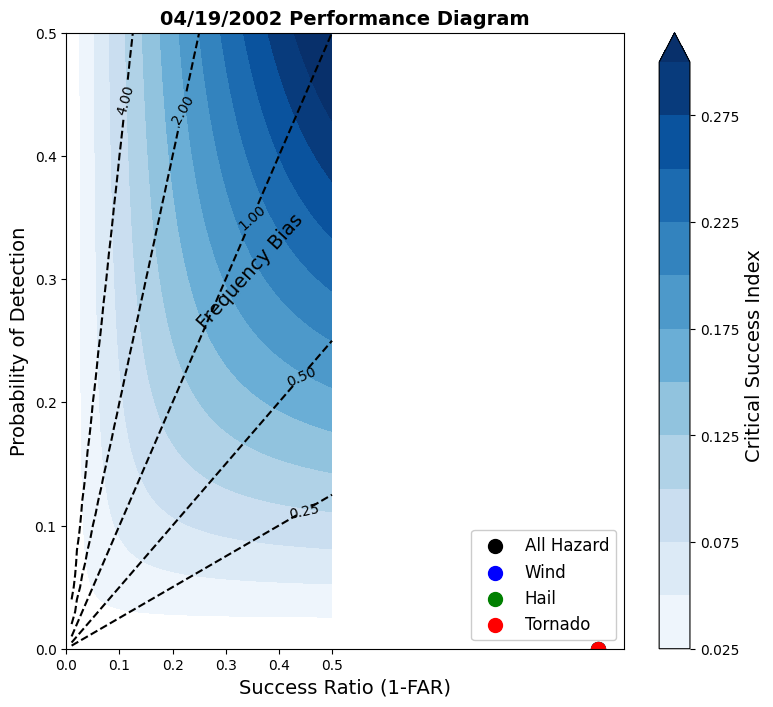

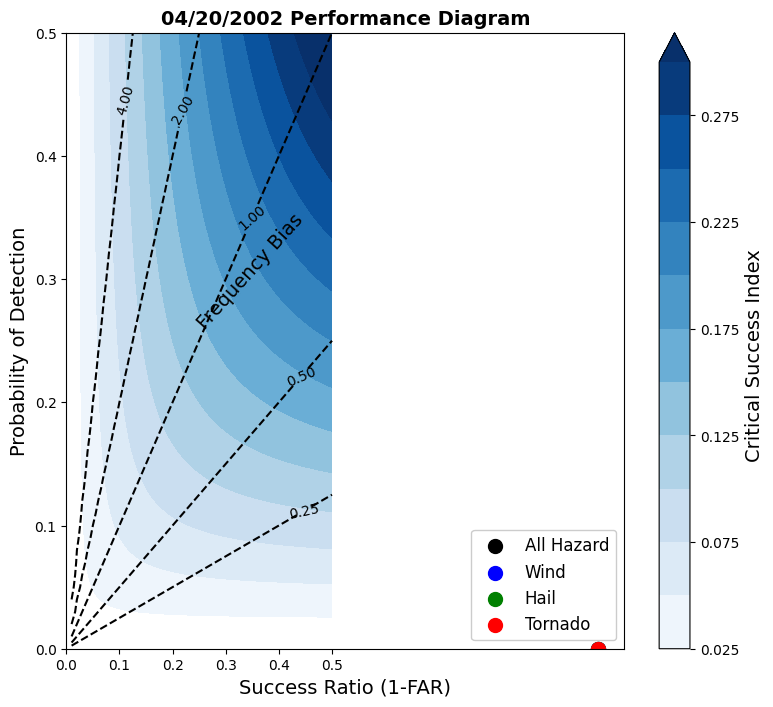

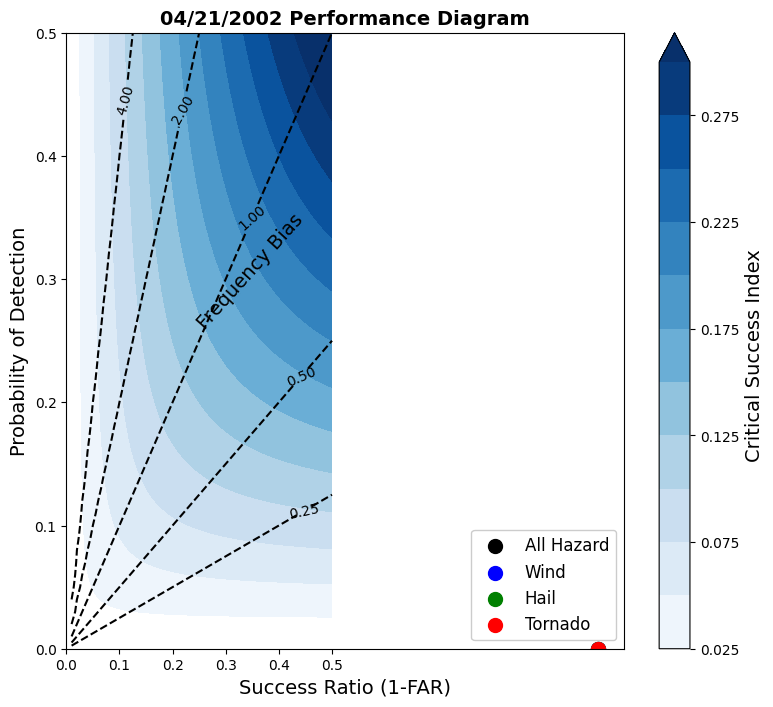

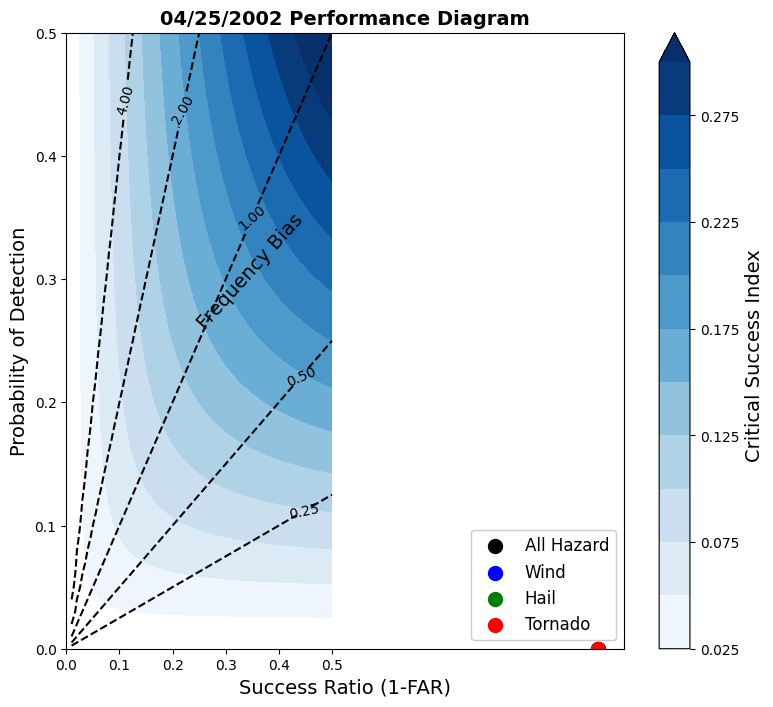

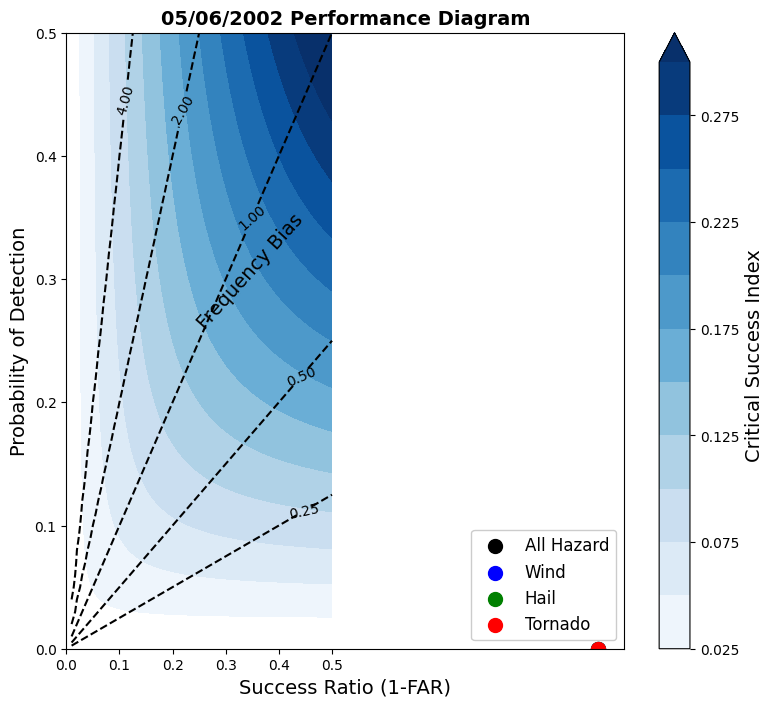

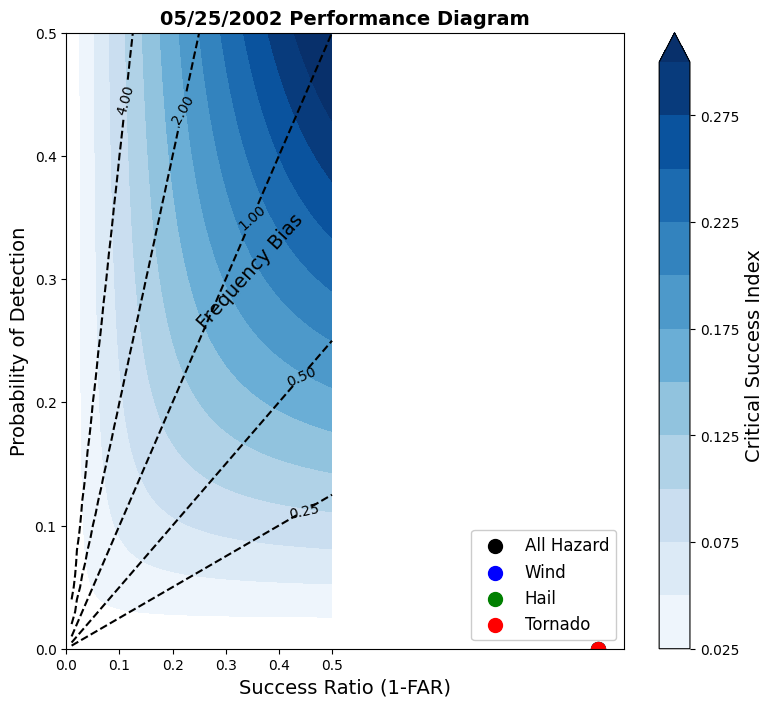

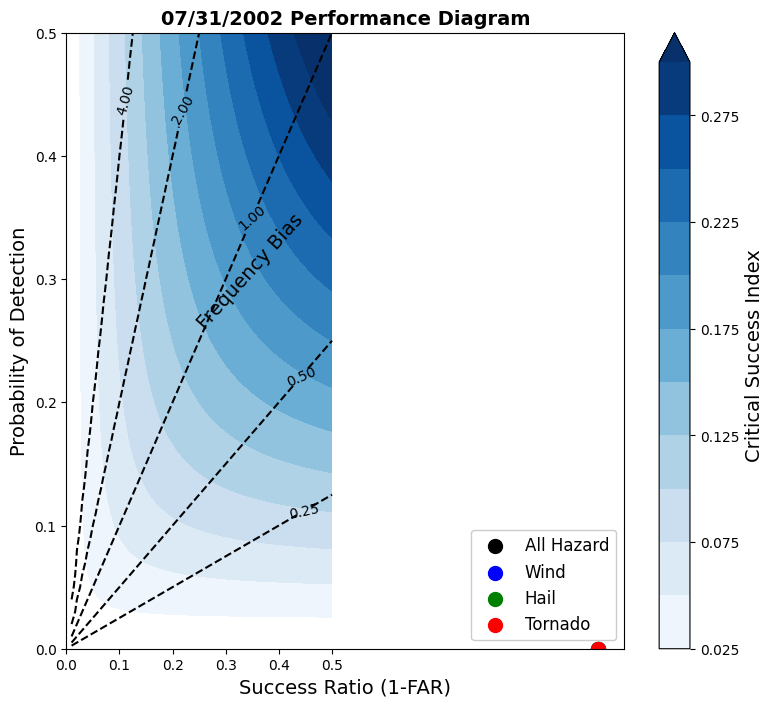

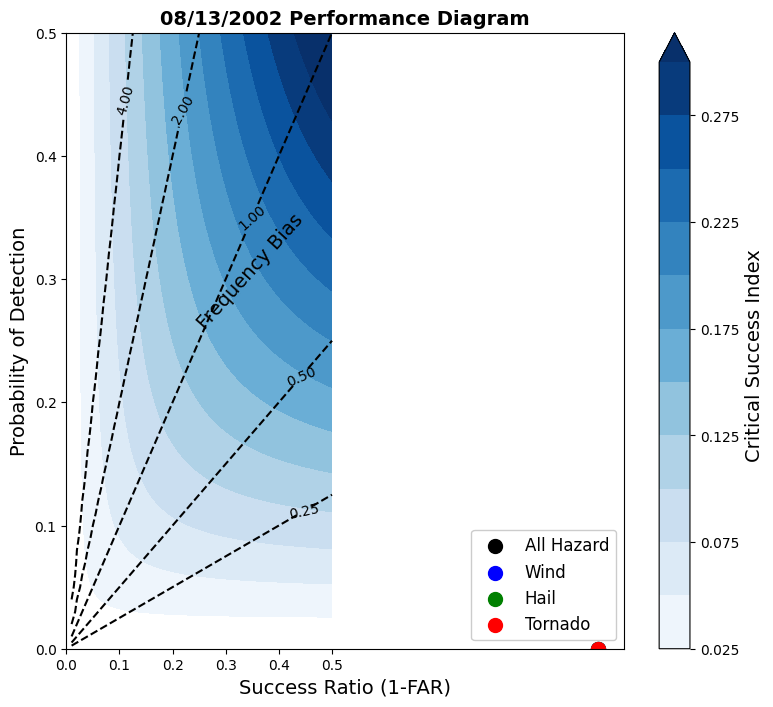

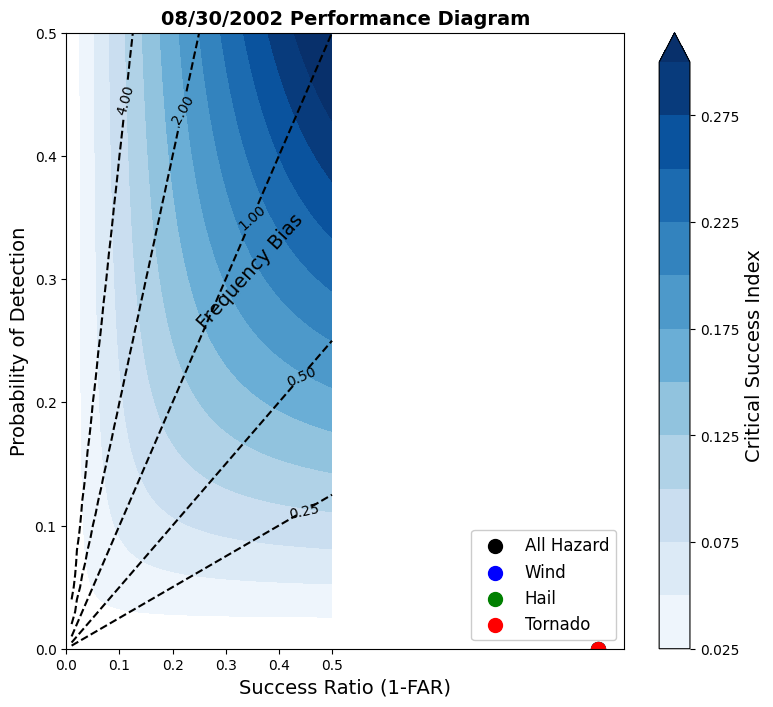

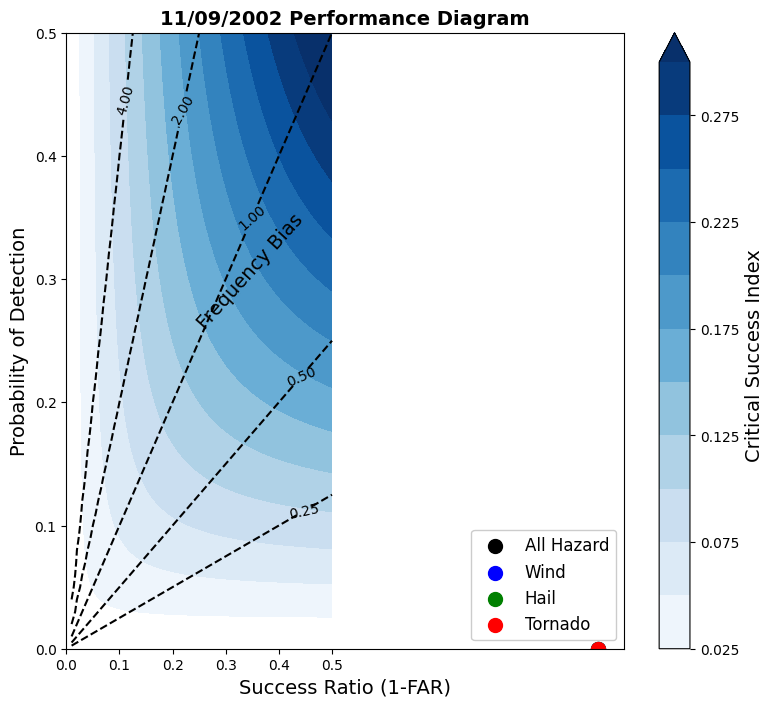

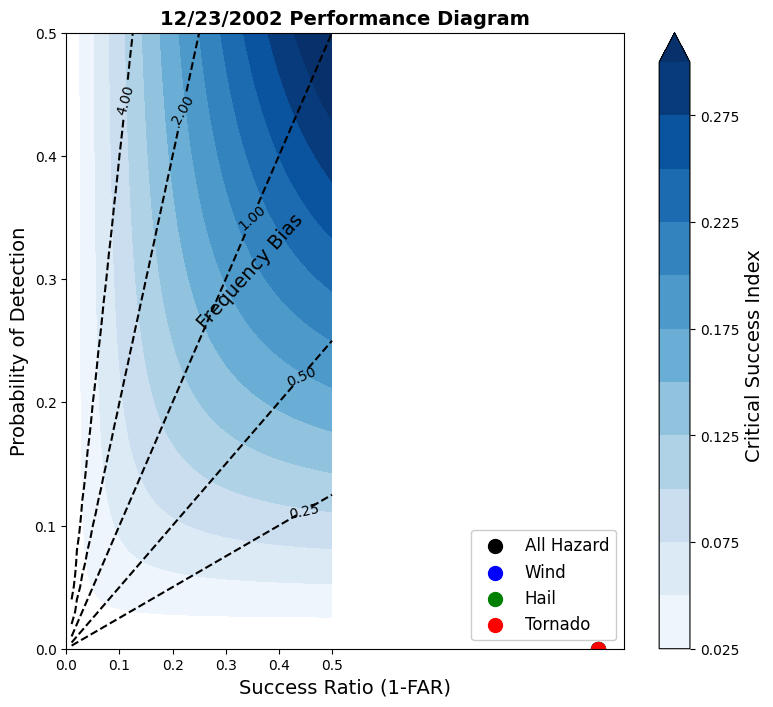

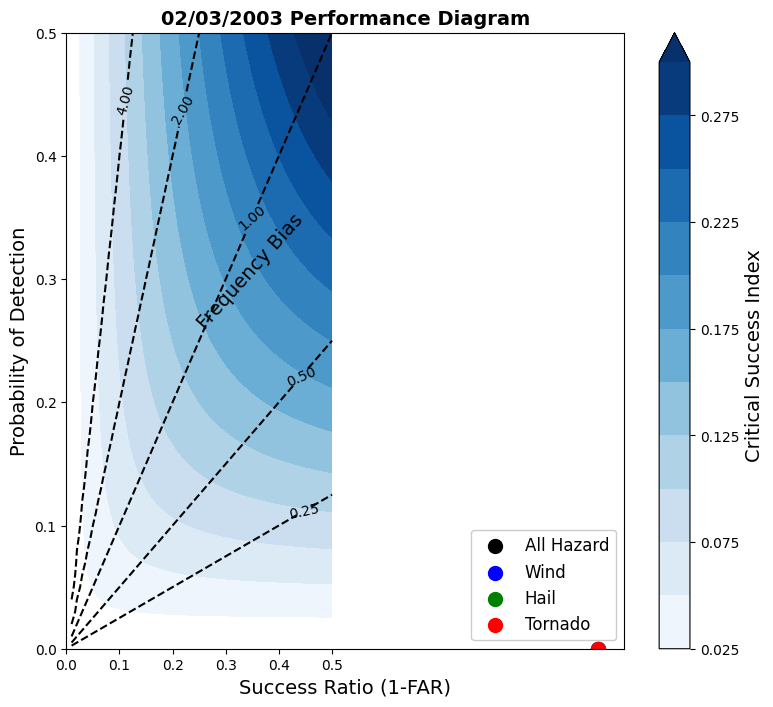

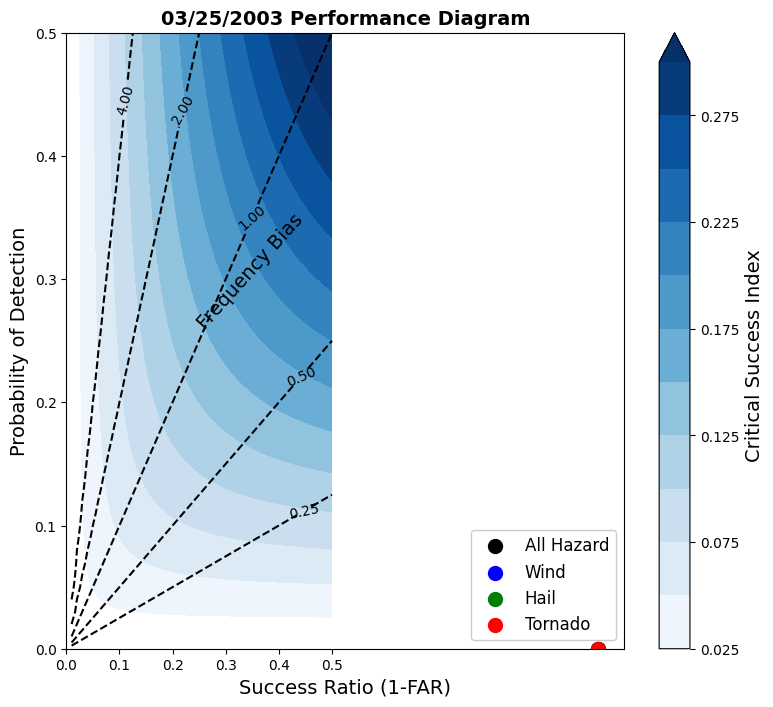

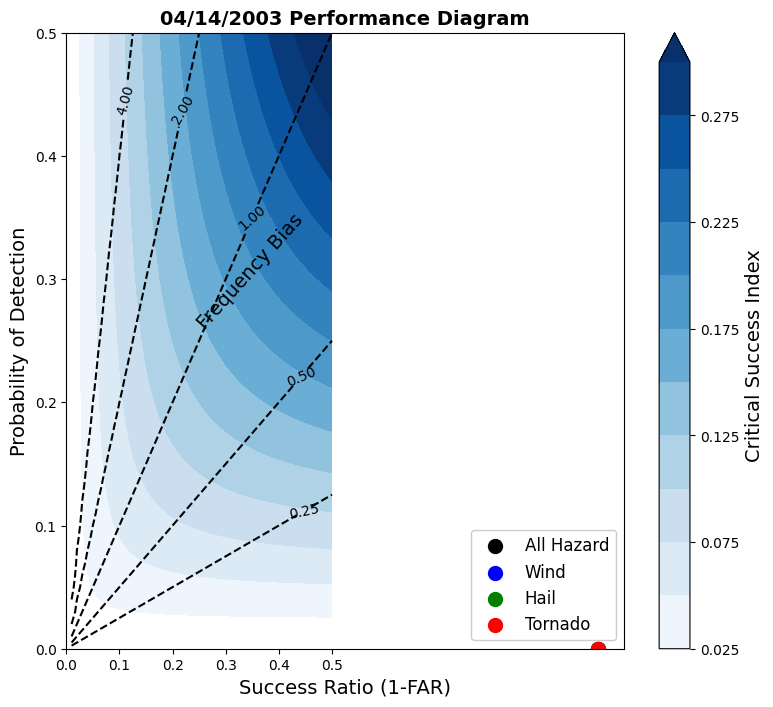

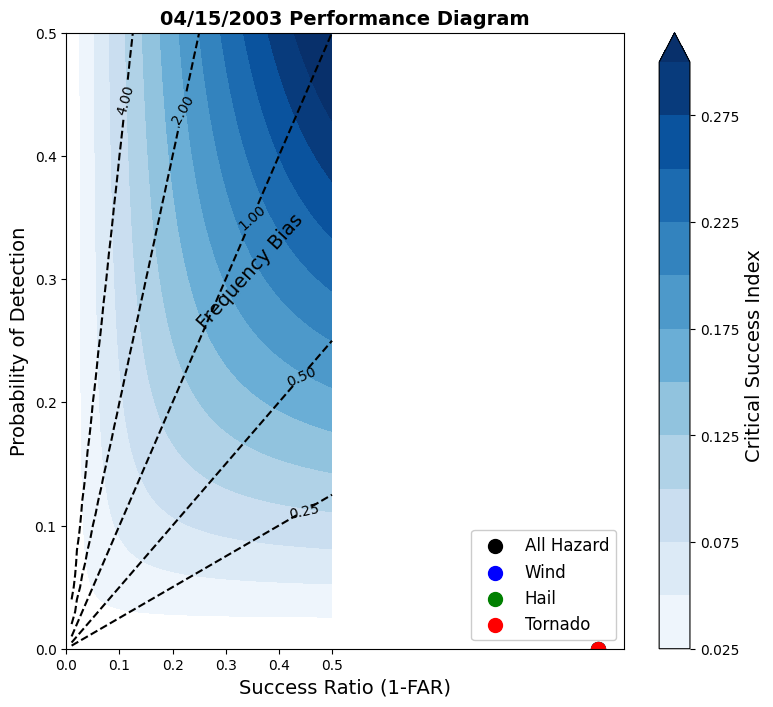

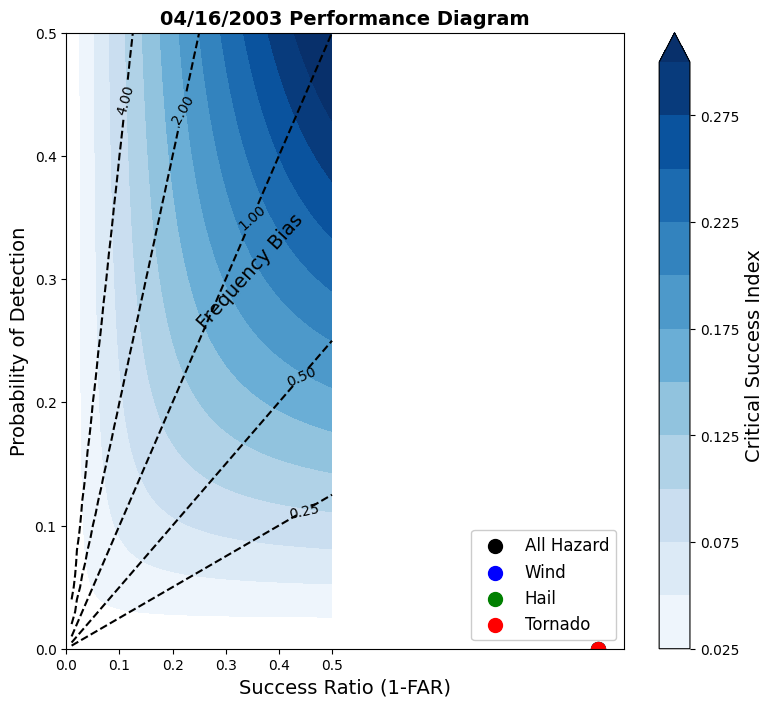

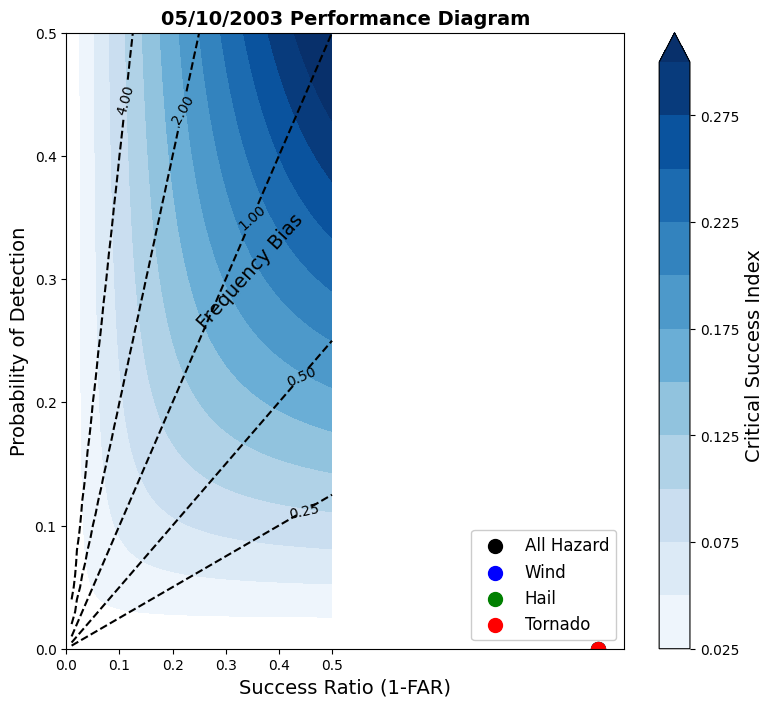

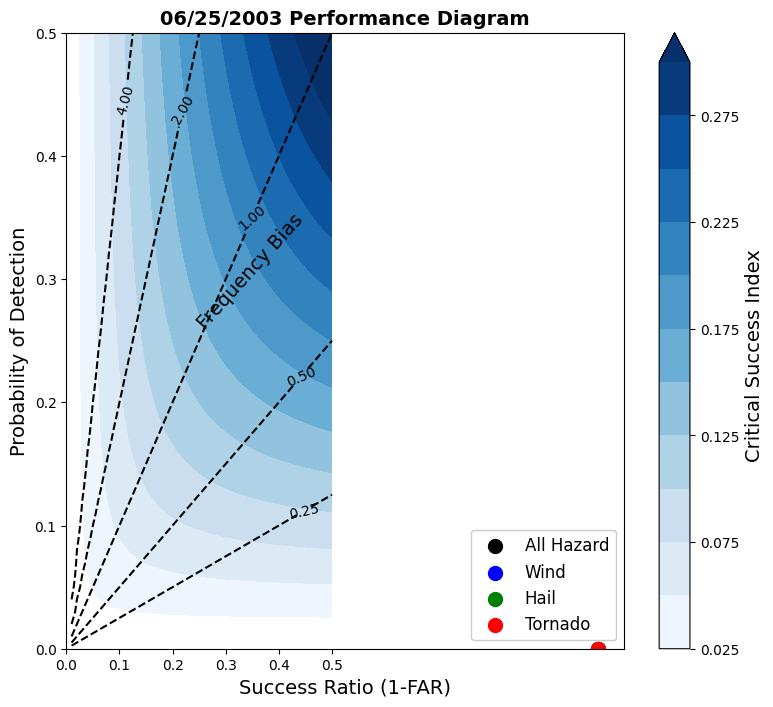

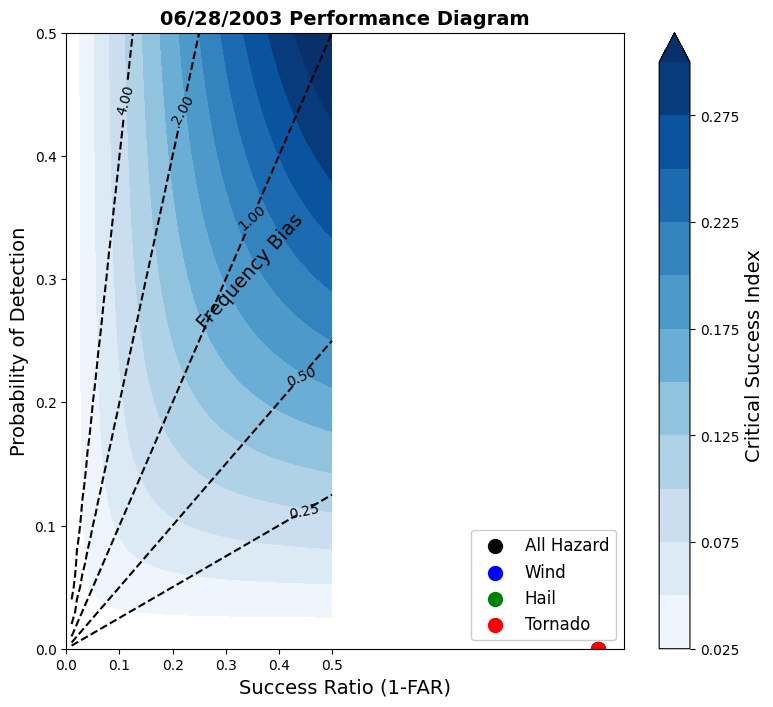

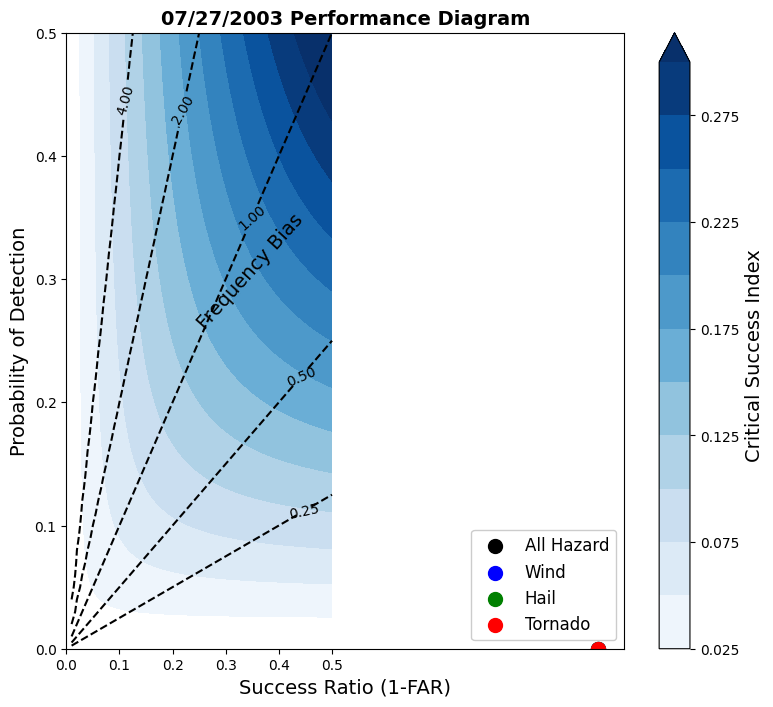

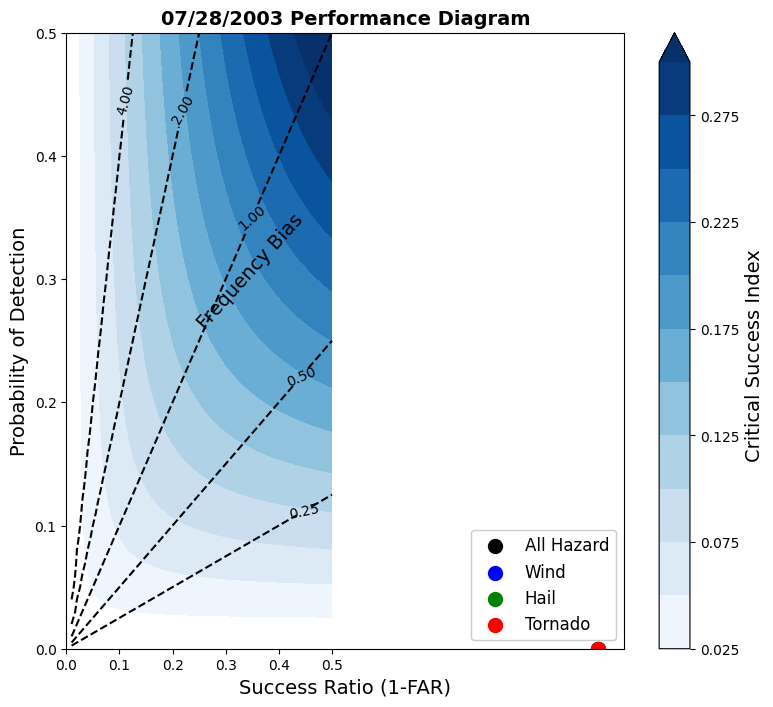

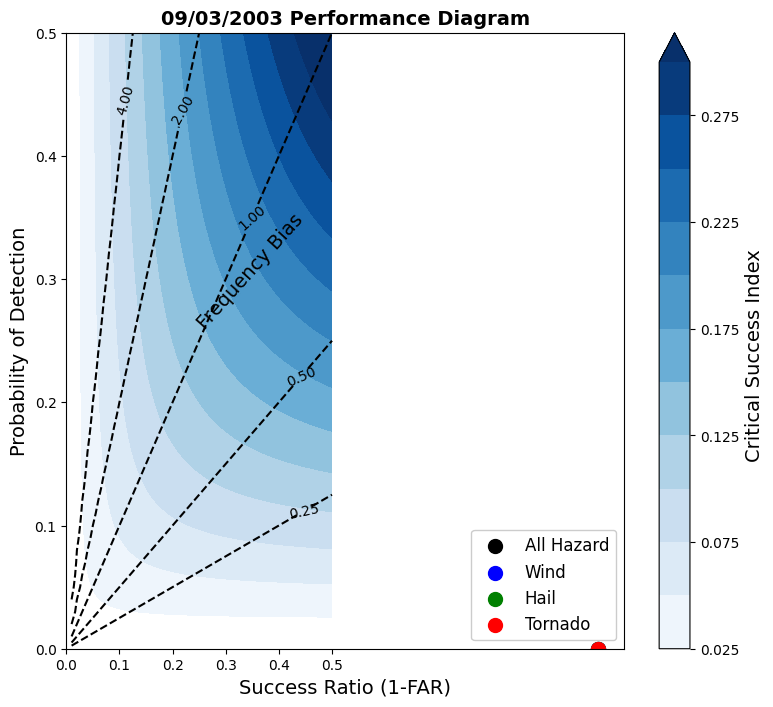

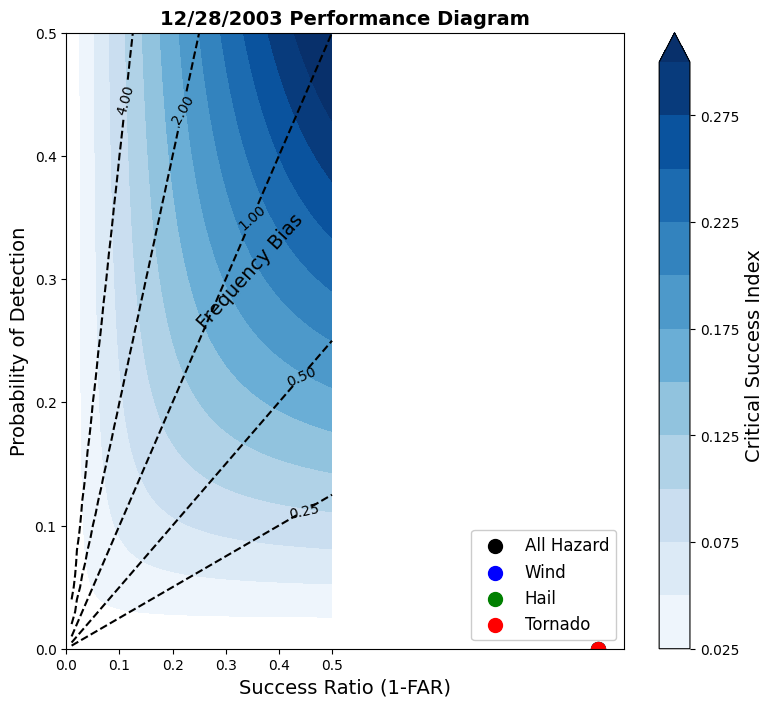

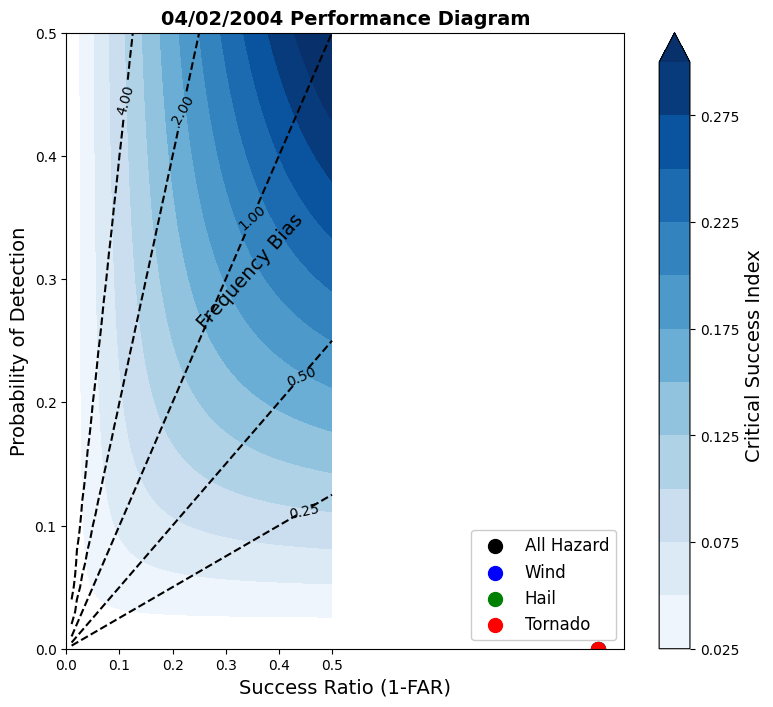

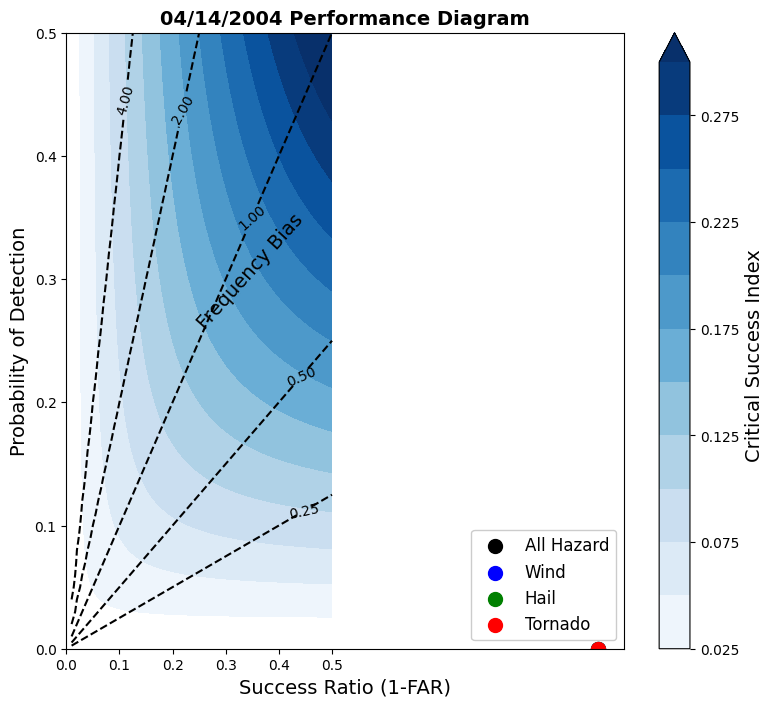

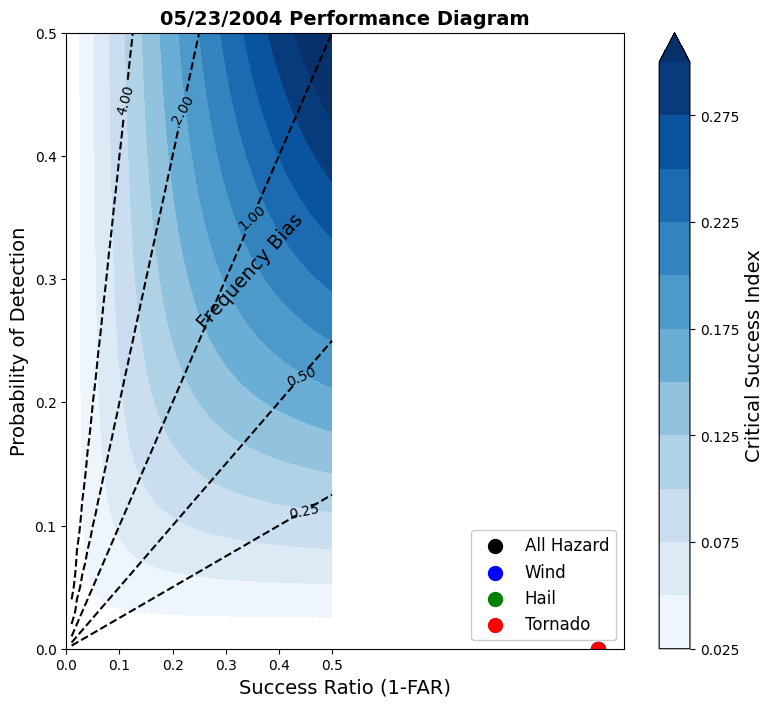

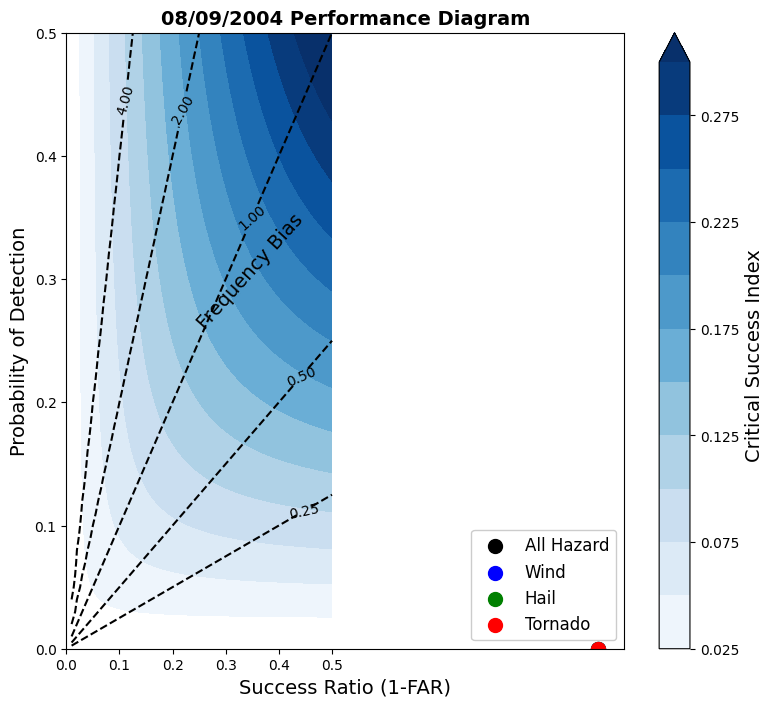

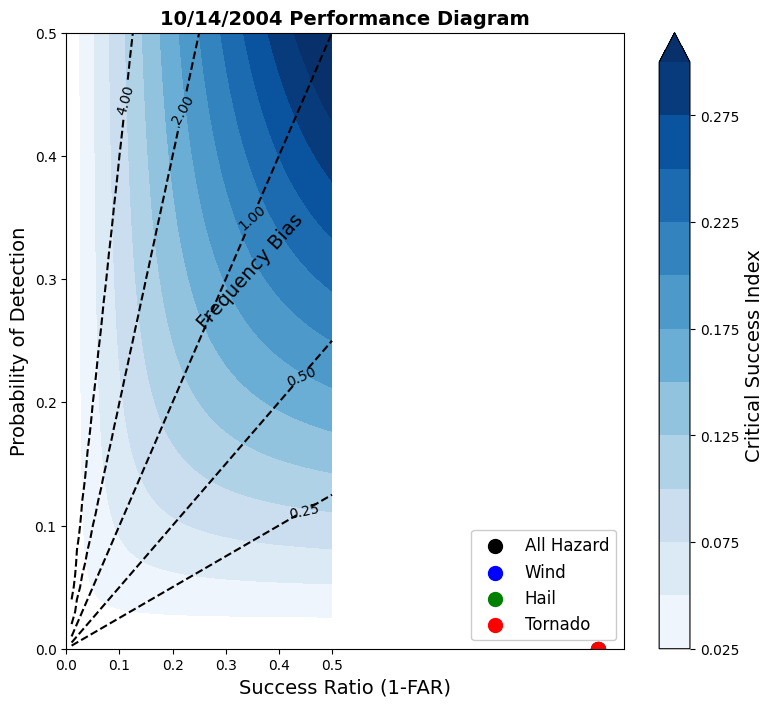

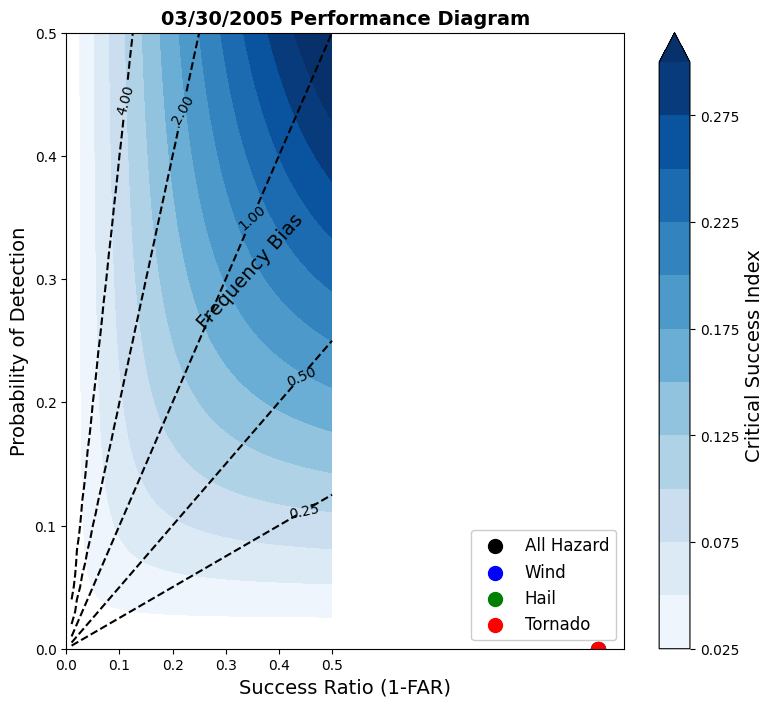

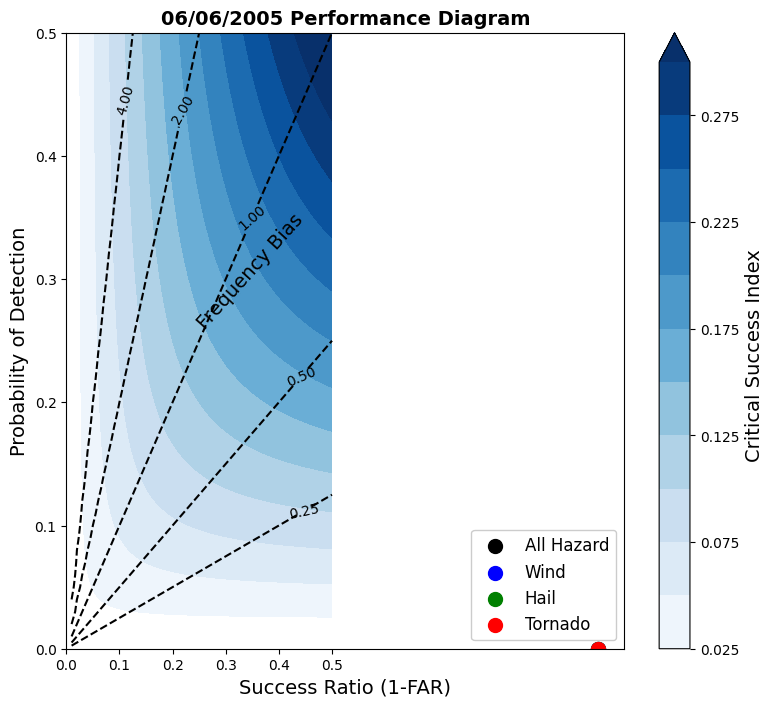

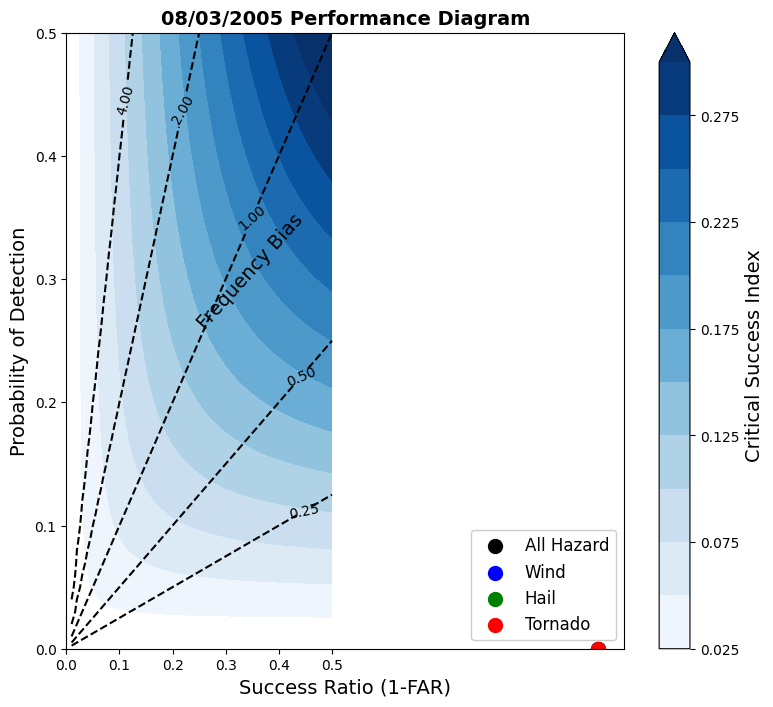

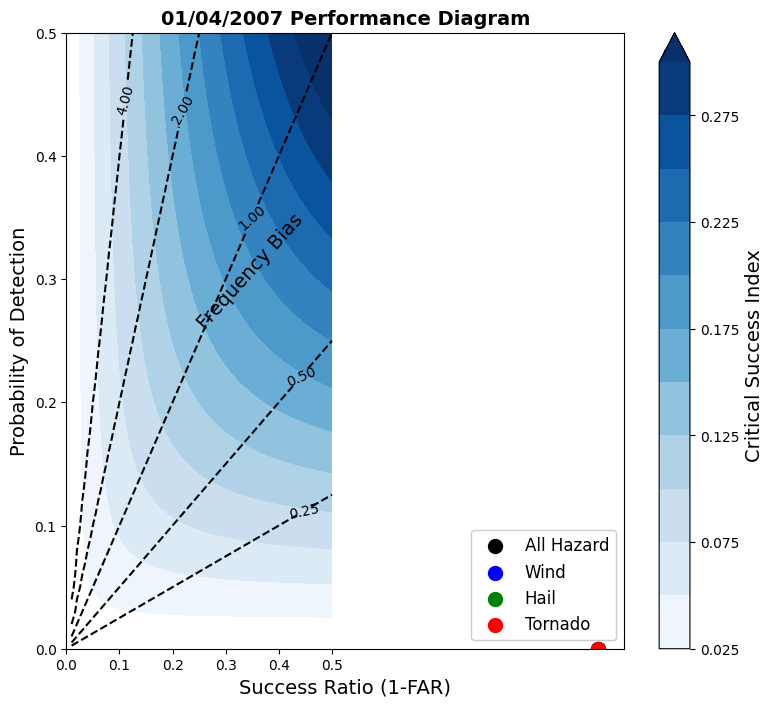

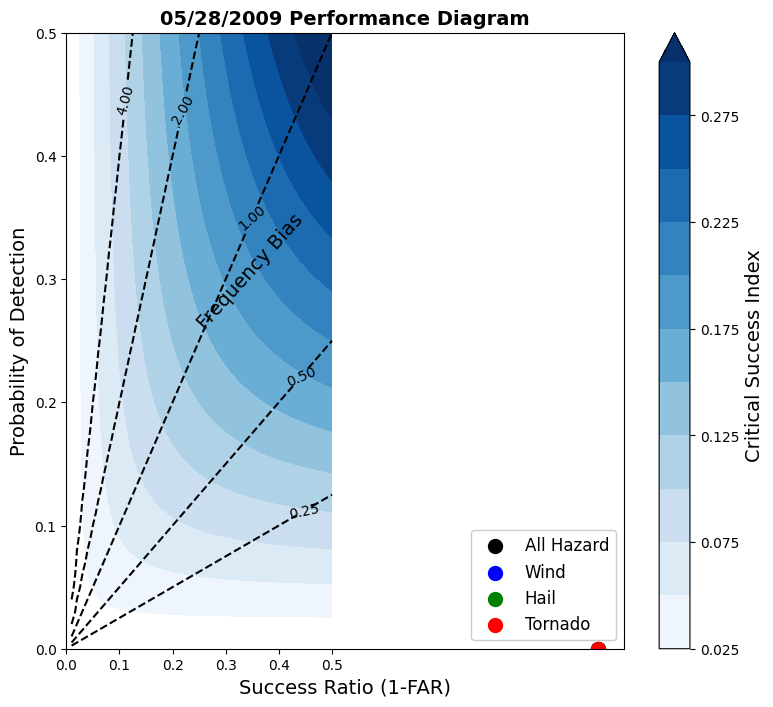

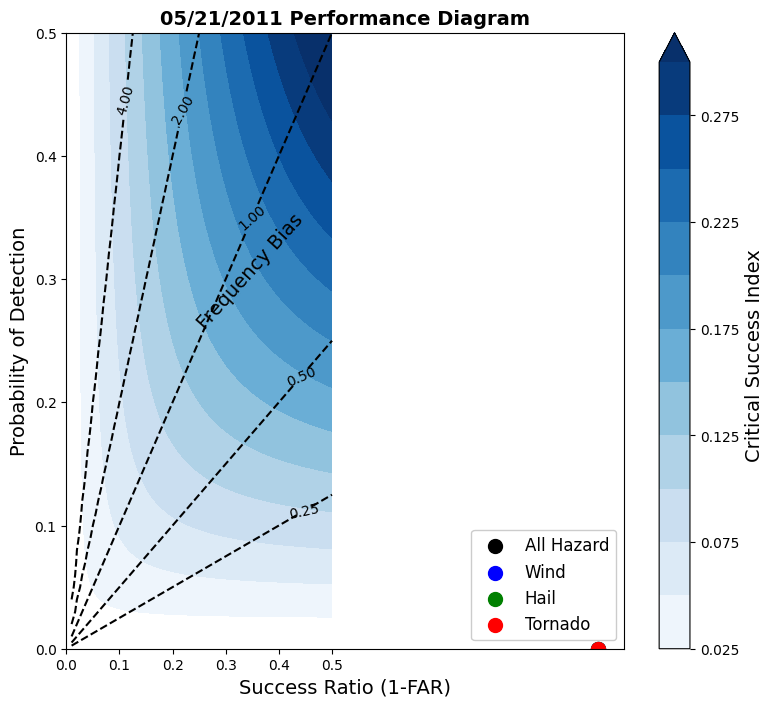

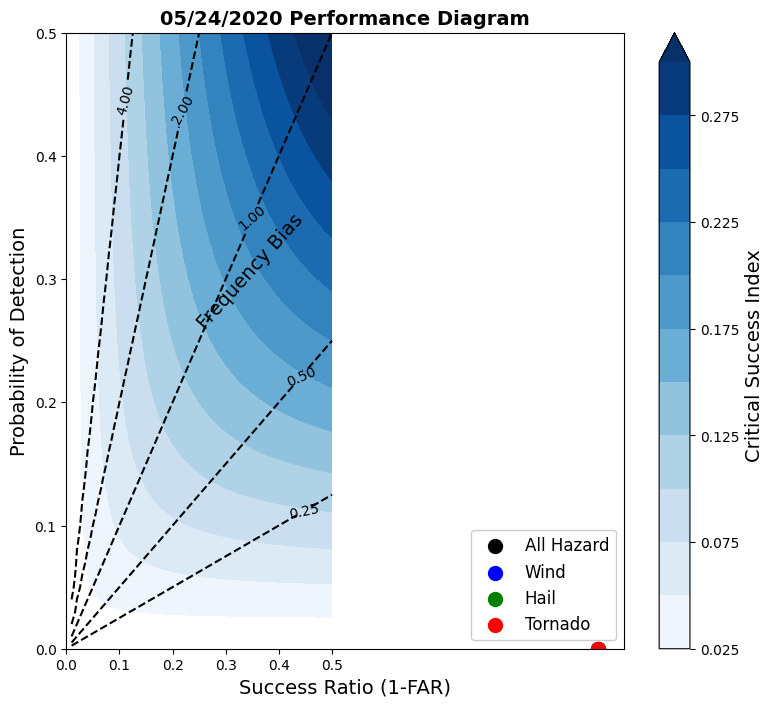

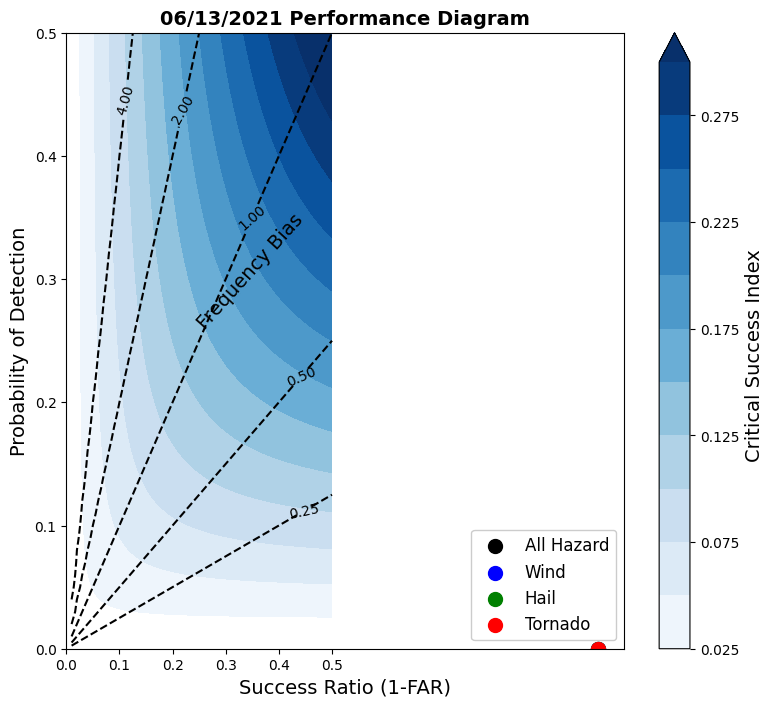

In [ ]:
dates_of_interest = ['200204190000', '200204200000', '200204210000', '200204250000', '200205060000', '200205250000', '200207310000', '200208130000', '200208300000', '200211090000', '200212230000', '200302030000', '200303250000', '200304140000', '200304150000', '200304160000', '200305100000', '200306250000', '200306280000', '200307270000', '200307280000', '200309030000', '200312280000', '200404020000', '200404140000', '200405230000', '200408090000', '200410140000', '200503300000', '200506060000', '200508030000', '200701040000', '200905280000', '201105210000', '202005240000', '202106130000']
for date in dates_of_interest:
    print(date)
    plot_day(date, grid_outlooks, pph, displacements, reports, 'plots/daily/missing/', show = False, save = True)